source: https://www.kaggle.com/code/stpeteishii/headlines-word2vec

In [1]:
import re
import numpy as np
import pandas as pd
from time import time
from collections import defaultdict
import spacy
from wordcloud import WordCloud
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

In [2]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


Device: grpc://10.0.0.2:8470
Number of replicas: 8


In [3]:
data0 = pd.read_csv('../input/million-headlines/abcnews-date-text.csv')
data0[0:5]

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [4]:
data0.isnull().sum()

publish_date     0
headline_text    0
dtype: int64

In [5]:
nlp=spacy.load('en',disable=['ner','parser'])

def cleaning(doc):
    txt=[token.lemma_ for token in doc if not token.is_stop]
    if len(txt)>2:
        return ' '.join(txt)

In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data0['headline_text'])

In [7]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print(txt[0:10])

['aba decide community broadcasting licence', 'act fire witness aware defamation', 'g call infrastructure protection summit', 'air nz staff aust strike pay rise', 'air nz strike affect australian traveller', 'ambitious olsson win triple jump', 'antic delight record breaking barca', 'aussie qualifier stosur waste memphis match', 'aust addresses un security council iraq', 'australia lock war timetable opp']


In [8]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print(df_clean[0:10])

(1152792, 1)
                                         clean
0    aba decide community broadcasting licence
1            act fire witness aware defamation
2      g call infrastructure protection summit
3            air nz staff aust strike pay rise
4    air nz strike affect australian traveller
5             ambitious olsson win triple jump
6          antic delight record breaking barca
7  aussie qualifier stosur waste memphis match
8      aust addresses un security council iraq
9             australia lock war timetable opp


In [9]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [10]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))

94757


In [11]:
words=sorted(word_freq, key=word_freq.get, reverse=True)
print(words[0:100])

['police', 'new', 'say', 'man', 'plan', 'council', 'win', 'fire', 'australia', 'charge', 'govt', 'nsw', 'woman', 'wa', 'death', 'kill', 'urge', 'report', 'australian', 'face', 'find', 'year', 'help', 'call', 'sydney', 'court', 'claim', 'hospital', 'qld', 'water', 'hit', 'change', 'warn', 'government', 'sa', 'attack', 'murder', 'accuse', 'miss', 'set', 'seek', 'day', 'school', 'open', 'home', 'election', 'boost', 'china', 'health', 'lead', 'talk', 'jail', 'nt', 'ban', 'worker', 'fight', 'die', 'case', 'rise', 'continue', 'farmer', 'group', 'cut', 'return', 'melbourne', 'push', 'm', 'end', 'family', 'want', 'fear', 'work', 'crash', 'minister', 'test', 'act', 'concern', 'deal', 'take', "'", 'support', 'labor', 'arrest', 'job', 'law', 'child', 'drug', 'hope', 'fund', 'get', 'queensland', 'leave', 'union', 'big', 'indigenous', 'car', 'close', 'trial', 'hold', 'defend']


Text(0.5, 1.0, '')

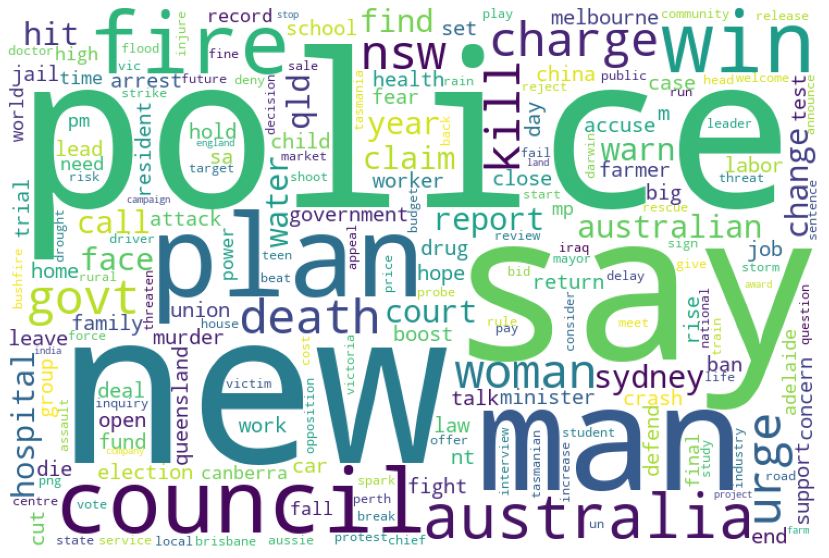

In [12]:
plt.figure(figsize=(15,10))
wordcloud = WordCloud(background_color='white',width=750,height=500).generate(" ".join(words))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('',fontsize=20)

In [13]:
cores = multiprocessing.cpu_count()
print(cores)

4


In [14]:
w2v_model = Word2Vec(min_count=20,window=2,vector_size=100,sample=6e-5, 
                    alpha=0.03,min_alpha=0.0007,negative=20,workers=cores-1)

In [15]:
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
w2v_model.wv.most_similar(positive=["covid"])

[('coronavirus', 0.9318570494651794),
 ('coronavirus_covid', 0.8330624103546143),
 ('covid_coronavirus', 0.7675978541374207),
 ('swine_flu', 0.7414259910583496),
 ('victoria_coronavirus', 0.7414257526397705),
 ('coronaviru', 0.6897069811820984),
 ('coronavirus_case', 0.6600077152252197),
 ('flu', 0.6531224250793457),
 ('coronavirus_queensland', 0.6526408791542053),
 ('ebola', 0.627304196357727)]

In [17]:
def tsnescatterplot(model, word, list_names):

    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    close_words = model.wv.most_similar([word])
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc =  PCA(n_components=10).fit_transform(arrays)
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)
    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

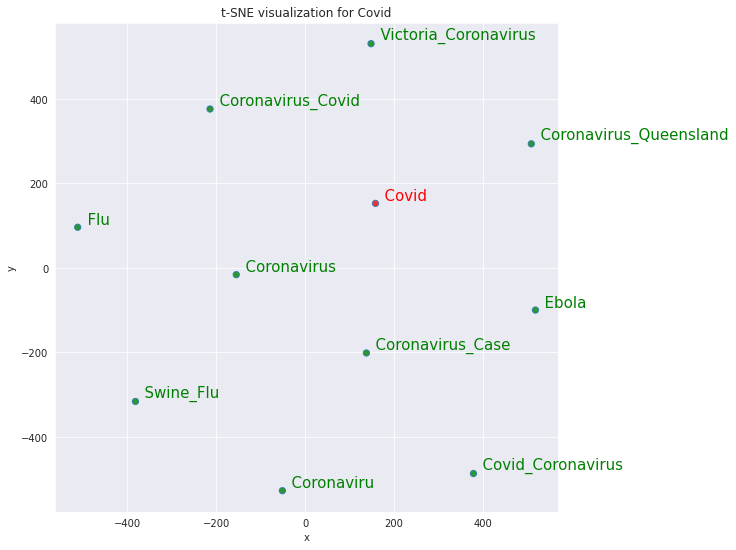

In [18]:
tsnescatterplot(w2v_model,'covid',[])